<a href="https://colab.research.google.com/github/Abde-Ali/Amazon-Food-Review/blob/main/EDA_and_Pre_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MachineLearning Projects/Reviews.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ProductId               568454 non-null  object
 1   UserId                  568454 non-null  object
 2   ProfileName             568438 non-null  object
 3   HelpfulnessNumerator    568454 non-null  int64 
 4   HelpfulnessDenominator  568454 non-null  int64 
 5   Score                   568454 non-null  int64 
 6   Time                    568454 non-null  int64 
 7   ReviewSummary           568427 non-null  object
 8   ReviewText              568454 non-null  object
dtypes: int64(4), object(5)
memory usage: 39.0+ MB


In [5]:
data.head(2)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,ReviewSummary,ReviewText
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [6]:
# filtered_data = data.drop(columns=['ProductId'])
dup = data[data.duplicated(subset=['UserId','ProfileName','Time','ReviewText'],keep=False)]
dup.shape

(232653, 9)

In [7]:
df = data.drop_duplicates(subset=['UserId','ProfileName','Time','ReviewText'],keep='first',inplace=False)
df.shape

(393758, 9)

In [8]:
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')

Remaining data is 69.26822574913713


In [9]:
df.shape

(393758, 9)

#Analyisis of Reviews over time

TypeError: tz must be string or tzinfo subclass.

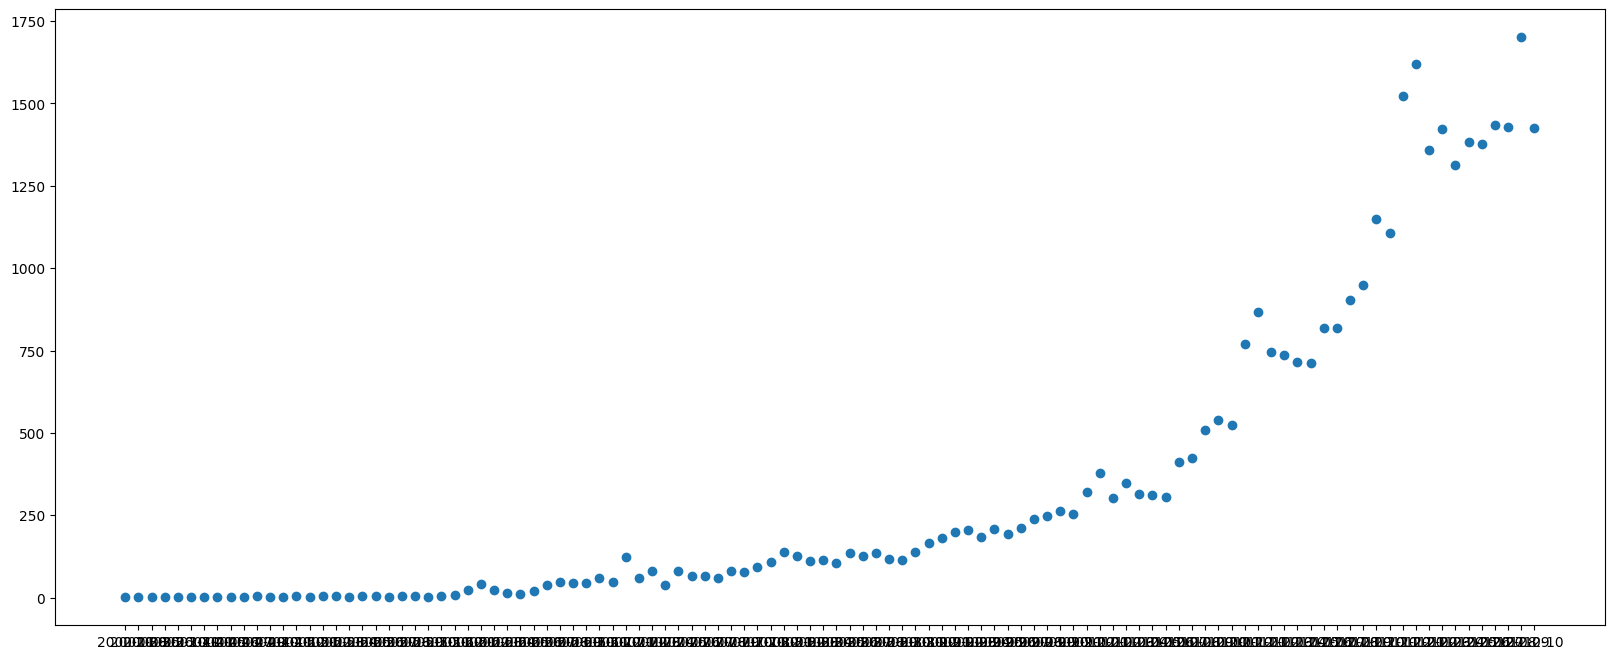

In [11]:
df['date'] = pd.to_datetime(df['Time'],unit='s')
dff = df[['date','ReviewText','Score']]
dff.date = df.date.dt.strftime('%Y-%m')
# dff['date'] = dff['date'].dt.to_timestamp()
dff = dff.sort_values(by=['date']).reset_index(drop=True)
dff_1 = dff[dff['Score'] == 1]
dff_2 = dff[dff['Score'] == 2]
dff_3 = dff[dff['Score'] == 3]
dff_4 = dff[dff['Score'] == 4]
dff_5 = dff[dff['Score'] == 5]

dff_1 = dff_1.groupby('date')['Score'].count().reset_index()
dff_2 = dff_2.groupby('date')['Score'].count().reset_index()
dff_3 = dff_3.groupby('date')['Score'].count().reset_index()
dff_5 = dff_4.groupby('date')['Score'].count().reset_index()
dff_4 = dff_4.groupby('date')['Score'].count().reset_index()

plt.figure(figsize=(20,8))

plt.plot_date(x=dff_1['date'],y=dff_1['Score'],label='Score=1')
plt.plot_date(x=dff_2['date'],y=dff_2['Score'],label='Score=2')
plt.plot_date(x=dff_3['date'],y=dff_3['Score'],label='Score=3')
plt.plot_date(x=dff_4['date'],y=dff_4['Score'],label='Score=4')
plt.plot_date(x=dff_5['date'],y=dff_5['Score'],label='Score=5')
plt.grid(linewidth=0.5,alpha=0.75)
plt.xticks(rotation=90)
plt.xlim('2000-01','2012-10')
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Review trend from 2000 to 2012',fontsize=24);
plt.savefig('review_trend.png')
plt.legend()
plt.show()

In [12]:
df = df[df['Score'] != 3]
df.shape
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')

Remaining data is 64.03455688586939


In [13]:
score = df['Score'].apply(lambda x: 1 if x > 3 else 0)
df['Score'] = score
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,ReviewSummary,ReviewText,date
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...,2012-10-26
2,B0019CW0HE,A2P6ACFZ8FTNVV,Melissa Benjamin,0,1,0,1331164800,Bad,I fed this to my Golden Retriever and he hated...,2012-03-08


#Analysis On ProductId and UserId

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df['Score'])
plt.title('Target')
plt.show()

In [16]:
# we will see the products brought by each customer

purchases = df[['ProductId','UserId']].groupby('UserId').agg({'ProductId': ['count']})
purchases.columns = ['No_of_products_purchased']
purchases = purchases.reset_index()
purchases.head(2)

,UserId,No_of_products_purchased
0,#oc-R103C0QSV1DF5E,1
1,#oc-R109MU5OBBZ59U,1


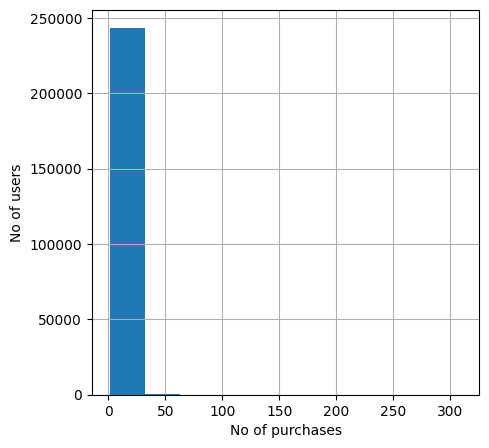

count    243410.000000
mean          1.495448
std           2.532922
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         310.000000
Name: No_of_products_purchased, dtype: float64


In [17]:
plt.figure(figsize=(5,5))
purchases['No_of_products_purchased'].hist()
plt.xlabel('No of purchases')
plt.ylabel('No of users')
plt.show()
print(purchases['No_of_products_purchased'].describe())

In [18]:
df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,ReviewSummary,ReviewText,date
385968,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,2008-06-08
528926,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,2008-10-25


In [19]:
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]
df.shape

(364005, 10)

In [20]:
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')

Remaining data is 64.03420505441073


In [28]:
df['text'] = df['ReviewSummary'] + df['ReviewText']


In [25]:
# replacing some phrases like won't with will not

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [32]:

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


'preprocessed_reviews = []\n# tqdm is for printing the status bar\nfor sentance in tqdm(df[\'text\'].values):\n  sentance = re.sub(r"http\\S+", "", sentance)\n  # removing html tags\n  sentance = BeautifulSoup(sentance, \'lxml\').get_text()\n  sentance = decontracted(sentance)\n  # removing extra spaces and numbers\n  sentance = re.sub("\\S*\\d\\S*", "", sentance).strip()\n  # removing non alphabels\n  sentance = re.sub(\'[^A-Za-z]+\', \' \', sentance)\n  # https://gist.github.com/sebleier/554280\n  sentance = \' \'.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)\n  preprocessed_reviews.append(sentance.strip())'

In [33]:
preprocessed_reviews = []

# tqdm is for printing the status bar
for sentence in tqdm(df['text'].values):
    # Convert the value to a string
    sentence = str(sentence)

    # Your preprocessing steps here
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)

    preprocessed_reviews.append(sentence.strip())


100%|██████████| 364005/364005 [03:01<00:00, 2007.83it/s]


In [34]:
#combining required columns
df['clean_text'] = preprocessed_reviews
df = df[['Time','clean_text','Score']]
#reseting index
df = df.reset_index(drop=True)
#saving processed file
df.to_csv('processed_df.csv',index=False)

In [35]:
df = pd.read_csv('processed_df.csv')
print(df.shape)
df.head()

(364005, 3)


,Time,clean_text,Score
0,1303862400,good quality dog foodi bought several vitality...,1
1,1351209600,healthy dog foodthis healthy dog food good dig...,1
2,1331164800,badi fed golden retriever hated would not eat ...,0
3,1332374400,not hot not habaneroi admit sucker large quant...,0
4,1337472000,best weve tried farwe week old gas constipatio...,1


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364005 entries, 0 to 364004
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        364005 non-null  int64 
 1   clean_text  364001 non-null  object
 2   Score       364005 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ MB


In [37]:
#one row is empty.we will drop it
df = df.dropna(axis=0)
df.shape

(364001, 3)

In [38]:
#sampling 100k points
df = df.sample(100000,random_state=100)

In [39]:
#sortimg based on time
df['Time'] = pd.to_datetime(df['Time'],unit='s')
df = df.sort_values('Time')
df = df.reset_index(drop=True)

In [40]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = df['clean_text']
y = df['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (70000,)
shape of X_test is (30000,)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [44]:
import os

In [46]:
pwd

'/content'

In [47]:
cd /content/drive/MyDrive/Intern

/content/drive/MyDrive/Intern


In [50]:
!makedir = 'saved_feats'

/bin/bash: line 1: makedir: command not found


In [51]:
np.save('saved_feats/X_train', X_train)
np.save('saved_feats/y_train', y_train)
np.save('saved_feats/X_test', X_test)
np.save('saved_feats/y_test', y_test)

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

# Example data
corpus = ["This is the first document.", "This document is the second document.", "And this is the third one."]

# Create a CountVectorizer instance
vectorizer = CountVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(corpus)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

print(feature_names)


['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


In [58]:
bow = CountVectorizer()
bow.fit(X_train)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = vectorizer.get_feature_names_out()
print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (70000, 70595)
shape of X_test_bow is (30000, 70595)


In [59]:
#saving bow vectors
import pickle
pickle.dump(X_train_bow, open("saved_feats/X_train_bow","wb"))
pickle.dump(X_test_bow, open("saved_feats/X_test_bow","wb"))
pickle.dump(np.array(bow_features), open("saved_feats/bow_features","wb"))

#Tfidf

In [61]:
#applying bow on x_train and x_test
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
tfidf_features = vectorizer.get_feature_names_out()
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [62]:
#saving tfidf vectors
pickle.dump(X_train_tfidf, open("saved_feats/X_train_tfidf","wb"))
pickle.dump(X_test_tfidf, open("saved_feats/X_test_tfidf","wb"))
pickle.dump(np.array(tfidf_features), open("saved_feats/tfidf_features","wb"))

Word2vec

In [67]:
from gensim.models import Word2Vec

# Assuming X_train is a pandas Series or DataFrame containing text data
preprocessed_reviews = X_train.values

# Split each review into a list of words
train_sentence = [rev.split() for rev in preprocessed_reviews]

# min_count = 5 considers only words that occurred at least 5 times
# vector_size = length of the word vectors
w2v_model_train = Word2Vec(train_sentence, min_count=5, vector_size=50, workers=4)

# Accessing the vocabulary using key_to_index
w2v_words = list(w2v_model_train.wv.key_to_index.keys())


In [68]:
pickle.dump(np.array(w2v_words),open("saved_feats/w2v_words","wb"))

Average Word2vec

In [69]:
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]

sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

########################################################
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]

sent_vectors_test = []
for sent in tqdm(test_sentence):
    count = 0
    sent_vec = np.zeros(50)
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            count += 1

    if count != 0:
        sent_vec /= count
    sent_vectors_test.append(sent_vec)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 70000/70000 [03:36<00:00, 323.56it/s]


70000
50


100%|██████████| 30000/30000 [01:18<00:00, 384.22it/s]

30000
50


In [71]:
X_train_avgw2v = np.array(sent_vectors_train)
X_test_avgw2v = np.array(sent_vectors_test)

pickle.dump(np.array(X_train_avgw2v), open("saved_feats/X_train_avgw2v","wb"))
pickle.dump(np.array(X_test_avgw2v), open("saved_feats/X_test_avgw2v","wb"))

Tfidf Word2Vec

In [75]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Assuming you have previously saved w2v_words using pickle
w2v_words = pickle.load(open("saved_feats/w2v_words", "rb"))

# Assuming X_train is a pandas Series or DataFrame containing text data
preprocessed_reviews = X_train.values

# Split each review into a list of words
train_sentence = [rev.split() for rev in preprocessed_reviews]

# min_count = 5 considers only words that occurred at least 5 times
# vector_size = length of the word vectors
w2v_model_train = Word2Vec(train_sentence, min_count=5, vector_size=50, workers=4)

# Accessing the vocabulary using key_to_index
w2v_model_train_words = list(w2v_model_train.wv.key_to_index.keys())

# Assuming w2v_words contains the words you want to keep
filtered_w2v_model_train_words = [word for word in w2v_model_train_words if word in w2v_words]

# Rest of your TF-IDF code
tfidf = TfidfVectorizer(vocabulary=filtered_w2v_model_train_words)
tfidf.fit(X_train)
dictionary = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names_out()

# Saving tfidf_feats
pickle.dump(tfidf_feats, open("saved_feats/tfidf_feats_w2v", "wb"))


In [76]:
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word]
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(sent_vectors_train[0])
X_train_tfw2v = sent_vectors_train

pickle.dump(np.array(X_train_tfw2v), open("saved_feats/X_train_tfw2v","wb"))

100%|██████████| 70000/70000 [1:22:17<00:00, 14.18it/s]


70000
[ 0.2740915   0.57821665 -0.02308435  0.37291111 -0.68704664 -0.44343
  0.07783231  0.32855245 -0.61231579 -0.45694675 -0.17896001 -1.20276648
 -0.10352845  0.88846981  0.26126742 -0.27275756  0.33656736  0.65978192
 -0.0686956   0.17780243 -0.01221662  0.99010819 -0.34215417 -0.07512895
 -0.01297778  0.63277314 -0.69078965  0.41046144 -0.21296446  0.23169938
  0.51170835  0.33505129  0.08675233  0.18745222 -0.17886951 -0.04884423
  1.00692232  0.03895703  0.18218262  0.19913163 -0.10409852  0.26507345
  0.1528992  -0.06049343 -0.18482238 -0.23963062 -0.1665375  -0.38868578
  0.40754457  0.20433986]


In [78]:
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]
sent_vectors_test = []
for sent in tqdm(test_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word]
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(sent_vectors_test[0])

100%|██████████| 30000/30000 [32:09<00:00, 15.55it/s]

30000
[ 0.25541837  0.32455976 -0.48992235  0.49235705 -0.9383936  -0.32855281
  0.63617055  0.6487206  -0.53675107  0.10867375 -1.07228526 -1.16199624
 -0.10825056  0.30701946 -1.18212723  0.12216331  0.62916104 -0.64340177
 -0.14085235  0.02082923  0.27031434  0.23357824 -0.26043173  0.67108693
 -0.16894493 -0.13114896  0.0155278  -0.20044268  0.03565422  0.67381353
 -0.21947293  0.35657347 -0.21480012  0.3170725  -0.8602261   0.06274668
  0.03161461  0.05723509 -0.03579772 -0.14196979 -0.69326033 -0.5721156
 -0.07613208  0.30652612 -0.25827235  0.15673838  0.02682574  0.31648987
 -0.12463237 -0.08404034]


In [79]:
X_test_tfw2v = sent_vectors_test

pickle.dump(np.array(X_test_tfw2v), open("saved_feats/X_test_tfw2v","wb"))

Loading saved vectors

In [80]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_train = np.load('saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (70000, 70595)
shape of X_test_bow is (30000, 70595)
shape of X_train_tfidf is (70000, 70595)
shape of X_test_tfidf is (30000, 70595)
shape of X_train_avgw2v is (70000, 50)
shape of X_test_avgw2v is (30000, 50)
shape of X_train_tfw2v is (70000, 50)
shape of X_test_tfw2v is (30000, 50)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [81]:
pwd

'/content/drive/MyDrive/Intern'